In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import os

np.random.seed(2)

In [ ]:
# 3. Classifiers:
# Probabilistic Classifier: Bayes classifier, Logistic regression
# Non-Probabilistic classifier: K-nearest neighbours
# 4. Decision Trees
# 5. Random Forests
# 6. Gradient Boosting
# Adaboost

In [ ]:
df=pd.read_csv('lend-or-lose/train.csv')
class_counts = df['Default'].value_counts()
print(class_counts)
df

Default
0    180524
1     23753
Name: count, dtype: int64


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,DRIRC89L0T,18,137576,209136,846,26,2,10.47,60,0.81,High School,Self-employed,Single,Yes,No,Business,No,0
1,TS0FIUNHNU,47,57194,5970,748,30,2,19.72,36,0.73,High School,Unemployed,Divorced,No,Yes,Education,No,0
2,I0YR284A1V,26,84328,95065,453,7,2,24.25,12,0.45,Master's,Self-employed,Married,No,No,Other,Yes,0
3,WB1T7NQV8A,53,49795,229582,533,107,3,14.44,60,0.17,Bachelor's,Self-employed,Single,Yes,No,Auto,Yes,1
4,J6GU9M4G1Z,49,115450,22072,840,0,4,24.48,12,0.11,Bachelor's,Part-time,Single,No,Yes,Education,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204272,KYS1HKNGGE,40,116623,161673,651,79,2,23.44,12,0.87,Bachelor's,Part-time,Divorced,No,No,Home,Yes,0
204273,5MAOH3AOZO,67,62958,189499,460,77,3,9.29,36,0.11,Bachelor's,Self-employed,Single,No,No,Business,Yes,0
204274,5Y9Z6NW29X,62,34372,59645,524,94,3,9.72,60,0.24,PhD,Full-time,Single,Yes,No,Auto,No,0
204275,O51974F566,44,146262,198454,489,7,4,4.31,48,0.30,High School,Self-employed,Married,Yes,No,Home,No,0


In [ ]:
le = LabelEncoder()

# Fit and transform the specified columns
for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    df[col] = le.fit_transform(df[col])

In [ ]:
features=df.columns.to_numpy()
features=features[(features!="LoanID") & (features!="Default")]
features  # Removes values at indices 1 and 3

array(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
       'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage',
       'HasDependents', 'LoanPurpose', 'HasCoSigner'], dtype=object)

In [ ]:
null_value_percentages=(df.isna().sum()/df.shape[0])*100
null_value_percentages

,0
LoanID,0.0
Age,0.0
Income,0.0
LoanAmount,0.0
CreditScore,0.0
MonthsEmployed,0.0
NumCreditLines,0.0
InterestRate,0.0
LoanTerm,0.0
DTIRatio,0.0


In [ ]:
class OutlierRemoval:
    def __init__(self, col):
        q1 = col.quantile(0.25)
        q3 = col.quantile(0.75)
        inter_quartile_range = q3 - q1
        self.upper_whisker = q3 + inter_quartile_range * 1.5
        self.lower_whisker = q1 - inter_quartile_range * 1.5
        self.has_outliers = False  # Track if outliers exist

    def replace_outlier(self, value):
        # Check if the value is an outlier and set `has_outliers` to True if it is
        if value < self.lower_whisker or value > self.upper_whisker:
            self.has_outliers = True
            return min(max(value, self.lower_whisker), self.upper_whisker)
        return value

def replace_outliers(df, columns):
    outlier_columns = []  # To store column names with outliers
    for col in columns:
        outlier_remover = OutlierRemoval(df[col])
        df[col] = df[col].apply(outlier_remover.replace_outlier)
        if outlier_remover.has_outliers:  # If outliers were replaced
            outlier_columns.append(col)
    print("Columns with outliers:", outlier_columns)  # Print the columns with outliers
    return df

# Replace outliers in the DataFrame `df` for selected columns
df = replace_outliers(df, features)
df


Columns with outliers: []


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,DRIRC89L0T,18,137576,209136,846,26,2,10.47,60,0.81,1,2,2,1,0,1,0,0
1,TS0FIUNHNU,47,57194,5970,748,30,2,19.72,36,0.73,1,3,0,0,1,2,0,0
2,I0YR284A1V,26,84328,95065,453,7,2,24.25,12,0.45,2,2,1,0,0,4,1,0
3,WB1T7NQV8A,53,49795,229582,533,107,3,14.44,60,0.17,0,2,2,1,0,0,1,1
4,J6GU9M4G1Z,49,115450,22072,840,0,4,24.48,12,0.11,0,1,2,0,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204272,KYS1HKNGGE,40,116623,161673,651,79,2,23.44,12,0.87,0,1,0,0,0,3,1,0
204273,5MAOH3AOZO,67,62958,189499,460,77,3,9.29,36,0.11,0,2,2,0,0,1,1,0
204274,5Y9Z6NW29X,62,34372,59645,524,94,3,9.72,60,0.24,3,0,2,1,0,0,0,0
204275,O51974F566,44,146262,198454,489,7,4,4.31,48,0.30,1,2,1,1,0,3,0,0


In [ ]:
scaler=StandardScaler()

normalized_features=scaler.fit_transform(df[features])
normalized_df = pd.DataFrame(normalized_features, columns=features)
normalized_df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,-1.699838,1.413785,1.151487,1.711544,-0.967182,-0.449530,-0.454811,1.415720,1.339989,-0.442742,0.448348,1.226590,0.999936,-1.000406,-0.707810,-1.000563
1,0.234120,-0.649831,-1.715866,1.094714,-0.851727,-0.449530,0.939092,-0.000645,0.993538,-0.442742,1.343560,-1.224023,-1.000064,0.999594,-0.000312,-1.000563
2,-1.166333,0.046770,-0.458437,-0.762072,-1.515594,-0.449530,1.621727,-1.417010,-0.219039,0.450557,0.448348,0.001284,-1.000064,-1.000406,1.414685,0.999437
3,0.634249,-0.839783,1.440049,-0.258537,1.370784,0.445809,0.143437,1.415720,-1.431615,-1.336042,0.448348,1.226590,0.999936,-1.000406,-1.415308,0.999437
4,0.367496,0.845753,-1.488613,1.673779,-1.717640,1.341148,1.656386,-1.417010,-1.691453,-1.336042,-0.446863,1.226590,-1.000064,0.999594,-0.000312,0.999437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204272,-0.232698,0.875867,0.481625,0.484177,0.562598,-0.449530,1.499667,-1.417010,1.599826,-1.336042,-0.446863,-1.224023,-1.000064,-1.000406,0.707187,0.999437
204273,1.567884,-0.501854,0.874343,-0.718013,0.504870,0.445809,-0.632628,-0.000645,-1.691453,-1.336042,0.448348,1.226590,-1.000064,-1.000406,-0.707810,0.999437
204274,1.234443,-1.235732,-0.958332,-0.315185,0.995555,0.445809,-0.567830,1.415720,-1.128471,1.343857,-1.342074,1.226590,0.999936,-1.000406,-1.415308,-1.000563
204275,0.034055,1.636778,1.000728,-0.535481,-1.515594,1.341148,-1.383075,0.707538,-0.868633,-0.442742,0.448348,0.001284,0.999936,-1.000406,0.707187,-1.000563


In [ ]:
ros = RandomOverSampler(random_state=2)
X_oversampled, Y_oversampled = ros.fit_resample(normalized_df, df["Default"])

rus = RandomUnderSampler(random_state=2)
X_undersampled, Y_undersampled = rus.fit_resample(normalized_df, df["Default"])

class_counts = Y_oversampled.value_counts()
print("After oversampling: ",class_counts)

class_counts = Y_undersampled.value_counts()
print("After undersampling: ",class_counts)

ros = RandomOverSampler(random_state=2)
X_oversampled_unnormalized, Y_oversampled_unnormalized = ros.fit_resample(df[features], df["Default"])

rus = RandomUnderSampler(random_state=2)
X_undersampled_unnormalized, Y_undersampled_unnormalized = ros.fit_resample(df[features], df["Default"])

After oversampling:  Default
0    180524
1    180524
Name: count, dtype: int64
After undersampling:  Default
0    23753
1    23753
Name: count, dtype: int64


In [ ]:
X_train_oversampled, X_test_oversampled, y_train_oversampled, y_test_oversampled = train_test_split(X_oversampled, Y_oversampled, test_size=0.2, random_state=2)
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled, Y_undersampled, test_size=0.2, random_state=2)

In [ ]:
def train_normalized(model,name,sample,X_train,Y_train,X_val,Y_val,X_test,loan_id):
    model.fit(X_train,Y_train)
    y_pred=model.predict(X_val)

    accuracy=accuracy_score(Y_val,y_pred)
    print(f'{name} with {sample}: {accuracy}')

    y_pred=model.predict(X_test)

    submission=pd.DataFrame({
        "LoanID":loan_id,
        "Default": y_pred
    })
    print(f'Results saved in {name}/{name}_{sample}.csv')
    submission.to_csv(f'{name}/{name}_{sample}.csv',index=False)

    return accuracy

In [ ]:
def train_grid(model,name,sample,X_train,Y_train,X_test):
  print("Started training")
  model.fit(X_train,Y_train)
  best_model=model.best_estimator_
  best_params = model.best_params_
  print("Best parameters:", best_params)
  acc=model.best_score_
  print("Best cross-validation accuracy:", acc)

  y_pred = best_model.predict(X_test)
  submission=pd.DataFrame({
      "LoanID":test_df["LoanID"],
      "Default": y_pred
  })

  submission.to_csv(f"{name}/{name}_{sample}.csv",index=False)

  return acc

In [ ]:
test_df=pd.read_csv("lend-or-lose/test.csv")

le = LabelEncoder()

# Fit and transform the specified columns
for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    test_df[col] = le.fit_transform(test_df[col])

test_normalized_df=scaler.transform(test_df[features])
test_normalized_df = pd.DataFrame(test_normalized_df, columns=features)
test_normalized_df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,0.767625,0.774024,-0.496148,0.043584,1.543966,-0.449530,1.514736,-0.000645,-1.518228,1.343857,0.448348,1.226590,0.999936,0.999594,0.707187,-1.000563
1,0.834313,0.232665,0.056842,0.421235,-0.158996,-1.344869,0.256456,-1.417010,-0.305651,-0.442742,-0.446863,-1.224023,0.999936,0.999594,-0.000312,0.999437
2,-1.166333,-0.111348,-0.735736,-0.031946,1.313056,0.445809,0.682915,-1.417010,-0.911940,0.450557,-0.446863,0.001284,0.999936,0.999594,-0.000312,0.999437
3,-1.166333,-0.499929,-1.647642,-1.561434,1.688285,-1.344869,0.184124,-0.708827,-0.392264,-0.442742,-0.446863,1.226590,-1.000064,-1.000406,-0.707810,0.999437
4,-1.299709,-1.356573,-1.501174,0.553413,1.226465,0.445809,0.230838,1.415720,0.820313,1.343857,1.343560,1.226590,-1.000064,0.999594,-0.707810,0.999437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51065,0.500872,0.435581,0.604129,0.339411,-1.024910,-1.344869,0.533730,-1.417010,-0.175732,1.343857,0.448348,-1.224023,0.999936,0.999594,-1.415308,0.999437
51066,-0.966268,-1.039490,-0.229109,-1.278196,-0.245588,1.341148,-0.962644,-0.000645,-0.002507,1.343857,0.448348,0.001284,-1.000064,-1.000406,1.414685,-1.000563
51067,1.567884,0.154056,0.213373,0.987712,-0.245588,-1.344869,1.416786,0.707538,1.253376,-1.336042,-0.446863,-1.224023,-1.000064,-1.000406,-0.000312,-1.000563
51068,-0.099321,0.876534,0.894652,-0.541775,-1.544458,-1.344869,-0.400562,1.415720,-0.782021,-1.336042,-1.342074,0.001284,-1.000064,0.999594,1.414685,0.999437


In [ ]:
os.makedirs("NaiveBayesClassifier", exist_ok=True)
train_normalized(GaussianNB(),"NaiveBayesClassifier","oversampled",X_train_oversampled,y_train_oversampled,X_test_oversampled,y_test_oversampled,test_normalized_df,test_df["LoanID"])
train_normalized(GaussianNB(),"NaiveBayesClassifier","undersampled",X_train_undersampled,y_train_undersampled,X_test_undersampled,y_test_undersampled,test_normalized_df,test_df["LoanID"])

NaiveBayesClassifier with oversampled: 0.6802381941559341
Results saved in NaiveBayesClassifier/NaiveBayesClassifier_oversampled.csv
NaiveBayesClassifier with undersampled: 0.6845355037889419
Results saved in NaiveBayesClassifier/NaiveBayesClassifier_undersampled.csv


0.6845355037889419

In [ ]:
os.makedirs("LogisticRegression", exist_ok=True)

train_normalized(LogisticRegression(random_state=2, max_iter=500),"LogisticRegression","oversampled",X_train_oversampled,y_train_oversampled,X_test_oversampled,y_test_oversampled,test_normalized_df,test_df["LoanID"])
train_normalized(LogisticRegression(random_state=2, max_iter=500),"LogisticRegression","undersampled",X_train_undersampled,y_train_undersampled,X_test_undersampled,y_test_undersampled,test_normalized_df,test_df["LoanID"])

LogisticRegression with oversampled: 0.6804136084568158
Results saved in LogisticRegression/LogisticRegression_oversampled.csv
LogisticRegression with undersampled: 0.6841145102441762
Results saved in LogisticRegression/LogisticRegression_undersampled.csv


0.6841145102441762

1 0.9388034898213544
2 0.9346212435950699


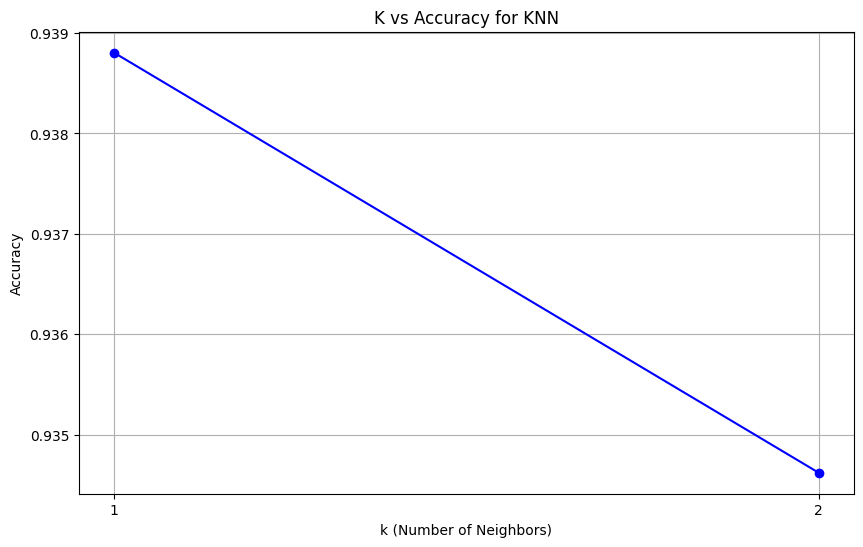

In [ ]:
os.makedirs("KNN", exist_ok=True)

k_values = range(1, 3)  # Adjust the upper limit if you want to test more values
accuracies = []
best_acc=0
knn_oversampled=None

# Loop over the range of k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_oversampled, y_train_oversampled)
    y_pred = knn.predict(X_test_oversampled)
    acc = accuracy_score(y_test_oversampled, y_pred)
    if acc>best_acc:
        best_acc=acc
        knn_oversampled=knn
    print(k,acc)
    accuracies.append(acc)

# Plot k vs. accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("K vs Accuracy for KNN")
plt.xticks(k_values)  # Make sure all values of k are shown on the x-axis
plt.grid(True)
plt.show()

In [ ]:
best_acc = 0
accuracies = []
k_values = range(28, 33)  # Adjust the upper limit if you want to test more values
knn_undersampled=None

# Loop over the range of k values
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_undersampled, y_train_undersampled)
    y_pred = knn.predict(X_test_undersampled)
    acc = accuracy_score(y_test_undersampled, y_pred)  # Calculate accuracy before the conditional check

    # Check if this is the best accuracy so far
    if acc > best_acc:
        best_acc = acc
        knn_undersampled = knn

    # Append the accuracy for the current k value to the accuracies list
    accuracies.append(acc)
    print(f"k = {k}, Accuracy = {acc:.4f}")

# Plot k vs. accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("K vs Accuracy for KNN")
plt.xticks(k_values)  # Make sure all values of k are shown on the x-axis
plt.grid(True)
plt.show()

In [ ]:
y_pred = knn_oversampled.predict(test_normalized_df)
submission_oversampled=pd.DataFrame({
    "LoanID":test_df["LoanID"],
    "Default": y_pred
})

# y_pred = knn_undersampled.predict(test_normalized_df)
# submission_undersampled=pd.DataFrame({
#     "LoanID":test_df["LoanID"],
#     "Default": y_pred
# })

submission_oversampled.to_csv("KNN/knn_oversampled.csv",index=False)
# submission_undersampled.to_csv("KNN/knn_undersampled.csv",index=False)

In [ ]:
# Define parameter grid for GridSearchCV
os.makedirs("DecisionTree", exist_ok=True)
dt_model = DecisionTreeClassifier(random_state=2)
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'max_features': [None, 'sqrt']
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt,
                           cv=5, scoring='accuracy', n_jobs=-1)

# train_grid(grid_search_dt,"DecisionTree","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)
# train_grid(grid_search_dt,"DecisionTree","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)
train_grid(grid_search_dt,"DecisionTree","",df[features],df['Default'],test_df[features])

train_grid(grid_search_dt,"DecisionTree","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])
# train_grid(grid_search_dt,"DecisionTree","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)


Started training
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.8822236496100089
Started training
Best parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 0.938958255031711


0.938958255031711

In [ ]:
# Define parameter grid for GridSearchCV
os.makedirs("RandomForest", exist_ok=True)

rf_model = RandomForestClassifier(random_state=2)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100],                   # Reduced to 1 option
    'max_depth': [10, None],                 # Reduced to 2 options
    'min_samples_split': [2],                # Reduced to 1 option
    'min_samples_leaf': [1, 4],              # 2 options
    'max_features': ['sqrt']                 # Reduced to 1 option
}

# Initialize GridSearchCV with the model, parameter grid, and evaluation method
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,               # 5-fold cross-validation
    scoring='accuracy', # Evaluation metric
    n_jobs=-1           # Use all available cores
)

train_grid(grid_search,"RandomForest","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)
# train_grid(grid_search,"RandomForest","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)
train_grid(grid_search,"RandomForest","",df[features],df['Default'],test_df[features])

train_grid(grid_search,"RandomForest","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])
# train_grid(grid_search_dt,"RandomForest","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)

Started training
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.990056725178462
Started training
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8857874317892296
Started training
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.9900788826209362


0.9900788826209362

In [ ]:
os.makedirs("GradientBoosting", exist_ok=True)

gb_model = GradientBoostingClassifier()

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [ 200],              # Reduced options to just two reasonable values
    'learning_rate': [0.05, 0.1],            # Narrowed down to two mid-range rates for refined control
    'max_depth': [3],                        # Fixed to 3 for simplicity and to prevent overfitting
    'min_samples_split': [2, 5],             # Kept as-is to test impact on splits without adding complexity
}

# Initialize GridSearchCV with the model, parameter grid, and evaluation method
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1  # Use all available cores
)

train_grid(grid_search,"GradientBoosting","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)
# train_grid(grid_search,"GradientBoosting","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)
train_grid(grid_search,"GradientBoosting","",df[features],df['Default'],test_df[features])

train_grid(grid_search,"GradientBoosting","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])
# train_grid(grid_search_dt,"GradientBoosting","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)

Started training
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.6940766855180487
Started training
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8861447895947061
Started training


In [ ]:
# Set up the enhanced AdaBoost model and parameter grid
os.makedirs("Adaboost", exist_ok=True)
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=2),
    random_state=2,
    algorithm='SAMME'  # Set explicitly to avoid warning and test new performance
)

# Enhanced parameter grid
param_grid = {
    'estimator__max_depth': [3],
    'n_estimators': [200],
    'learning_rate': [0.01, 0.1, 1]
}

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=adaboost_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',  # Keep this or try other metrics like 'f1' if applicable
    n_jobs=-1
)

# Execute the training function
train_grid(grid_search, "Adaboost", "normalized_oversampled", X_oversampled, Y_oversampled, test_normalized_df)
train_grid(grid_search,"Adaboost","",df[features],df['Default'],test_df[features])
train_grid(grid_search, "Adaboost", "oversampled", X_oversampled_unnormalized, Y_oversampled_unnormalized, test_df[features])


In [ ]:
os.makedirs("XGboost", exist_ok=True)
xgb_model = XGBClassifier(random_state=2)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [ 200],                 # Reduced to cover 200 as in desired combination
    'learning_rate': [0.05, 0.1],               # Reduced options around 0.1
    'max_depth': [3, 5],                        # Reduced around 3 as in desired combination
    'subsample': [0.8],                         # Set to 0.8 as in desired combination
    'colsample_bytree': [0.8]                   # Set to 0.8 as in desired combination
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',  # Change this metric based on your requirements
    n_jobs=-1
)

train_grid(grid_search,"XGboost","normalized_oversampled",X_oversampled,Y_oversampled,test_normalized_df)
# train_grid(grid_search,"XGboost","normalized_undersampled",X_train_undersampled,y_train_undersampled,test_normalized_df)
train_grid(grid_search,"XGboost","",df[features],df['Default'],test_df[features])

train_grid(grid_search,"XGboost","oversampled",X_oversampled_unnormalized,Y_oversampled_unnormalized,test_df[features])
# train_grid(grid_search_dt,"XGboost","undersampled",X_undersampled_unnormalized,Y_undersampled_unnormalized,test_normalized_df)